In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
import scipy.stats as stats
import scipy.ndimage
import altair as alt

%config InlineBackend.figure_format = 'retina'

First, load the dataset.

In [2]:
raw = pd.read_csv('flights-10m.csv')
# raw = pd.read_csv('flights-10m.csv', nrows=10000000)

In [3]:
raw.head(10)

,FlightDate,DepTime,DepDelay,ArrTime,ArrDelay,AirTime,Distance
0,2006-01-01,905.0,5.0,1229.0,19.0,350.0,2475.0
1,2006-01-02,1147.0,167.0,1546.0,216.0,343.0,2475.0
2,2006-01-03,853.0,-7.0,1208.0,-2.0,344.0,2475.0
3,2006-01-04,855.0,-5.0,1157.0,-13.0,331.0,2475.0
4,2006-01-05,857.0,-3.0,1153.0,-17.0,321.0,2475.0
5,2006-01-06,856.0,-4.0,1138.0,-32.0,320.0,2475.0
6,2006-01-08,857.0,-3.0,1208.0,-2.0,346.0,2475.0
7,2006-01-09,903.0,3.0,1210.0,0.0,334.0,2475.0
8,2006-01-10,853.0,-7.0,1149.0,-21.0,334.0,2475.0
9,2006-01-11,908.0,8.0,1200.0,-10.0,321.0,2475.0


In [4]:
raw.describe()

,DepTime,DepDelay,ArrTime,ArrDelay,AirTime,Distance
count,9.804829e+06,9.804829e+06,9.782658e+06,9.782658e+06,9.782658e+06,9.999999e+06
mean,1.340564e+03,1.035189e+01,1.486322e+03,8.973483e+00,1.034883e+02,7.257895e+02
std,4.769494e+02,3.394769e+01,5.020951e+02,3.705296e+01,6.803664e+01,5.699106e+02
min,1.000000e+00,-1.200000e+03,1.000000e+00,-5.920000e+02,-2.000000e+00,1.100000e+01
25%,9.300000e+02,-4.000000e+00,1.110000e+03,-9.000000e+00,5.400000e+01,3.160000e+02
50%,1.330000e+03,0.000000e+00,1.516000e+03,-1.000000e+00,8.500000e+01,5.740000e+02
75%,1.732000e+03,1.000000e+01,1.911000e+03,1.300000e+01,1.320000e+02,9.550000e+02
max,2.400000e+03,1.752000e+03,2.400000e+03,1.779000e+03,1.283000e+03,4.962000e+03


Below, change the configuration for the fields we want to look at.

In [74]:
ranges = {
    "AirTime": [0, 300],
    "ArrDelay": [-20, 50],
    "DepTime": [0, 2400],
    "ArrTime": [0, 2400],
    "DepDelay": [-10, 50],
    "Distance": [200, 2000]
}

active = "AirTime"
passive = "ArrDelay"
active_range = ranges[active]
passive_range = ranges[passive]

pixels = 500
bins = 25

In [75]:
df = raw[
    (active_range[0] <= raw[active]) & (raw[active] < active_range[1]) &
    (passive_range[0] <= raw[passive]) & (raw[passive] < passive_range[1])]

## Compute count matrix

Now, compute the count matrix for the active and passive dimensions. For this, aggregate into a binned matrix. 

In [76]:
bins_active = np.linspace(active_range[0], active_range[1], pixels + 1)
bins_passive = np.linspace(passive_range[0], passive_range[1], bins + 1)

hist, xedges, yedges = np.histogram2d(df[active], df[passive], bins=(bins_active, bins_passive))

In [77]:
# add 0s as the first row

pdf = np.vstack([np.zeros(bins), hist])

<BarContainer object of 25 artists>

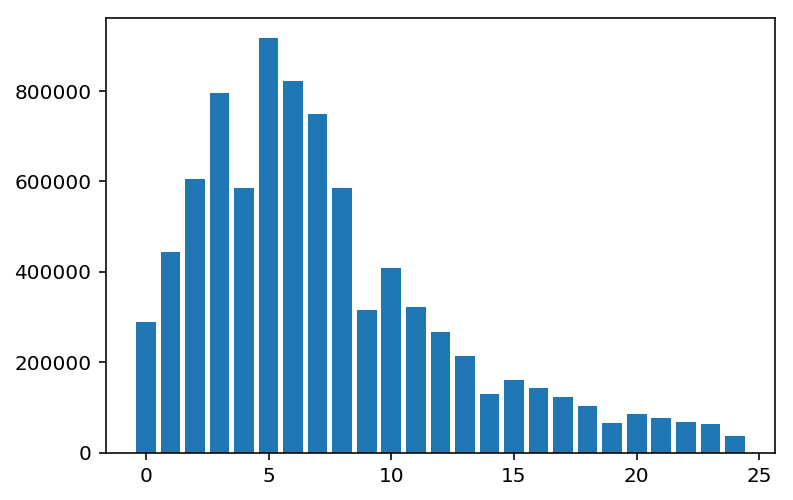

In [78]:
# compute unfiltered histogram and render it

unfiltered, edges = np.histogram(df[passive], bins=bins_passive)
plt.bar(np.arange(len(unfiltered)), unfiltered)

In [79]:
def show(a, size=(6,6)):
    """ Helper function to show a matrix. """
    print("Shape:", a.shape)
    plt.figure(figsize=size)
    plt.imshow(a, aspect='auto')
    plt.colorbar()

Let's look at the PDF of the count matrix. 

Shape: (501, 25)


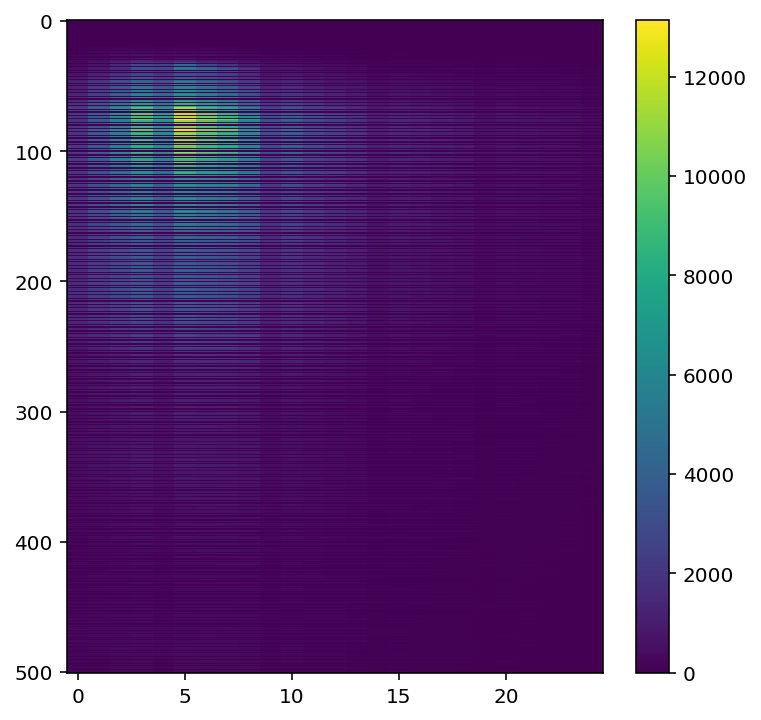

In [80]:
show(pdf)

Shape: (25, 501)


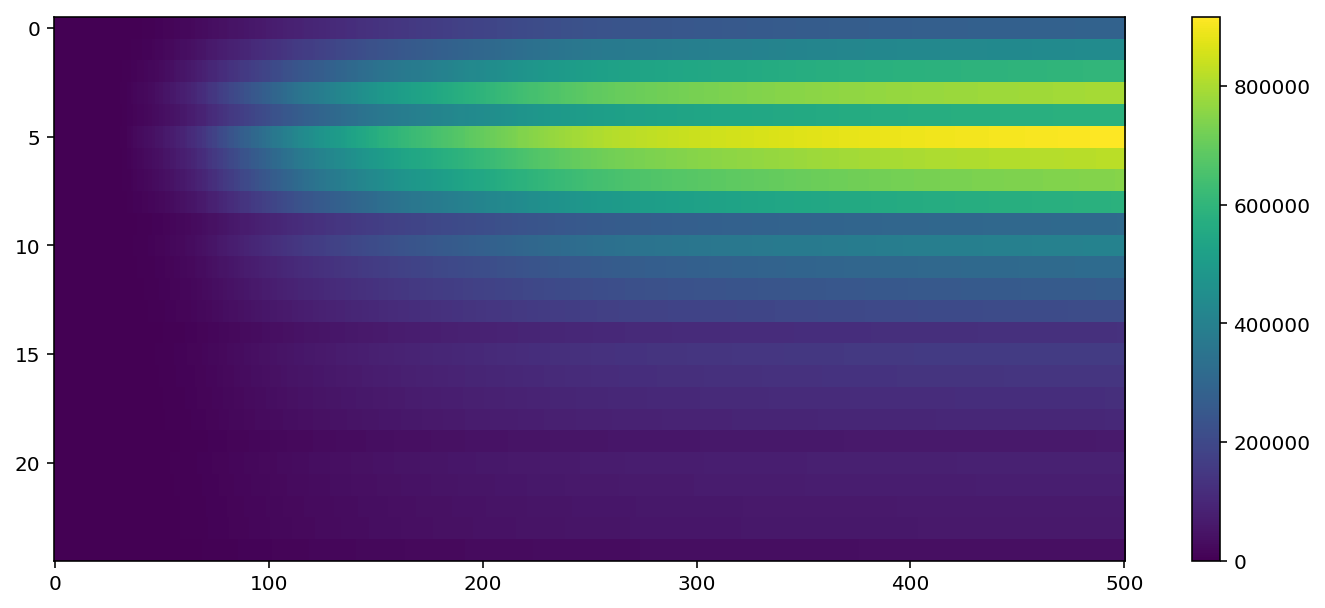

In [81]:
# used to make the data tile figure in the paper
show(np.cumsum(pdf, axis=0).T, (12, 5))

## Compute cumulative count matrix

Now, compute a cumulative count matrix. The cumulative version is computed along the active dimension. 

In [82]:
cdf = np.cumsum(pdf, axis=0)

Shape: (501, 25)


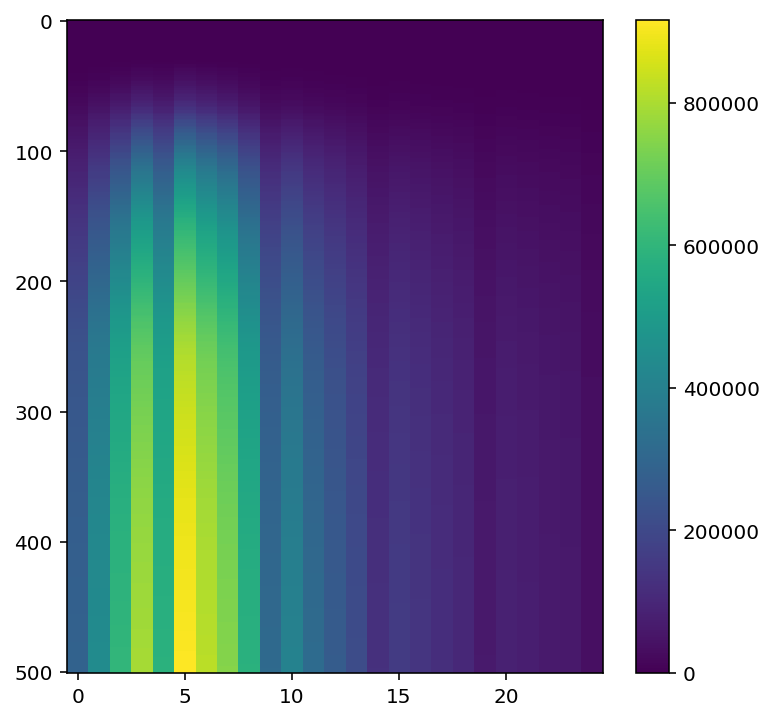

In [83]:
show(cdf)

## Interpolation from low resolution

Okay, now that we have a cumulative count matrix, we could compute the conditional histograms from this. However, the count matrix is a bit large. Let's see how well we could do the same from a lower resolution version. 

To do this, we first create a low resolution cdf where we pick every k rows. Then we use simple linear interpolation along the columns to get back something as close as possible to the original cumulative count matrix. 

Width 20.0
Row indexes [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400, 420, 440, 460, 480, 500]
Shape: (26, 25)


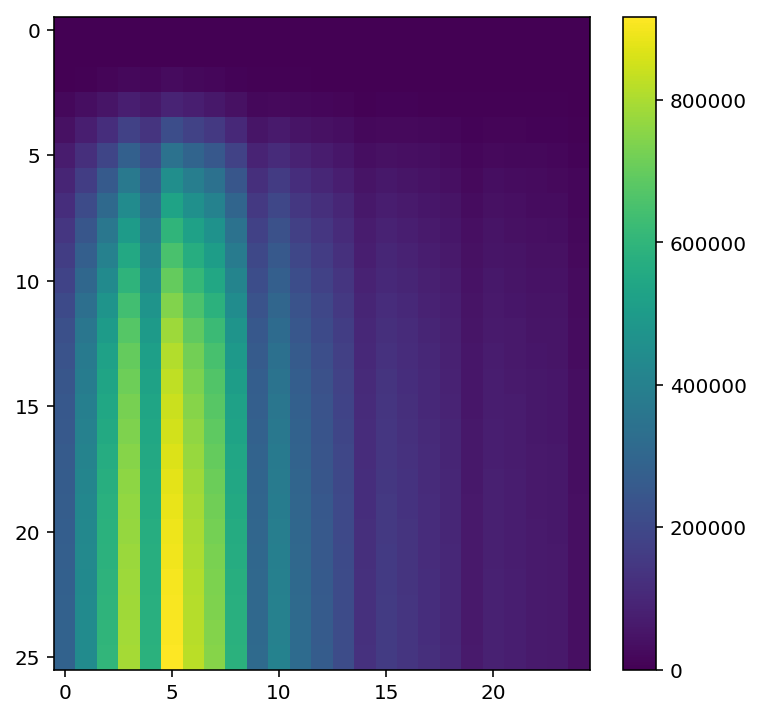

In [84]:
print("Width", pixels/bins)
idx = list(range(0,pixels+1, int(pixels/bins)))
print("Row indexes", idx)
low_res = cdf[idx, :]
show(low_res)

In [85]:
# compute the interpolated cdf as the same dimensions as the high resolution cdf

# i = interpolate.interp1d(np.arange(pixels), cdf, kind="linear", axis=0)
p = np.arange(0, pixels+1, pixels/bins);
print("Value locations: ", p)
i = interpolate.interp1d(p, low_res, kind="linear", axis=0)

to_interpolate = np.arange(0, pixels+1)
interpolated_cdf = i(to_interpolate)

assert interpolated_cdf.shape == cdf.shape, f"Interpolated matrix does not have the right dimensions {interpolated_cdf.shape} != {cdf.shape}"

Value locations:  [  0.  20.  40.  60.  80. 100. 120. 140. 160. 180. 200. 220. 240. 260.
 280. 300. 320. 340. 360. 380. 400. 420. 440. 460. 480. 500.]


Shape: (501, 25)


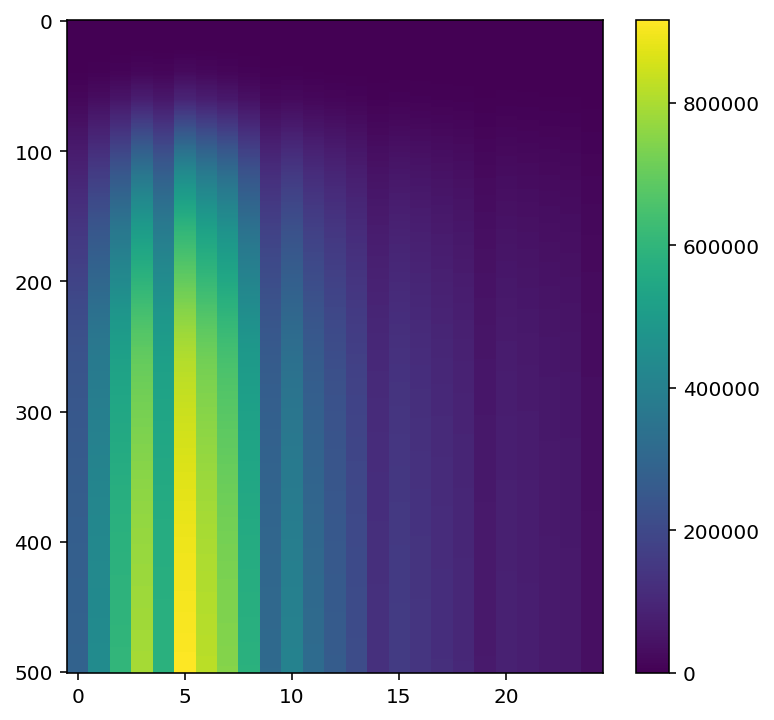

In [86]:
show(interpolated_cdf)

This looks pretty good but how close is it actually to the original cumulative count matrix?

## Evaluation

First, let's visualize the difference betwen the interpolation and the true CDF. 

Shape: (501, 25)


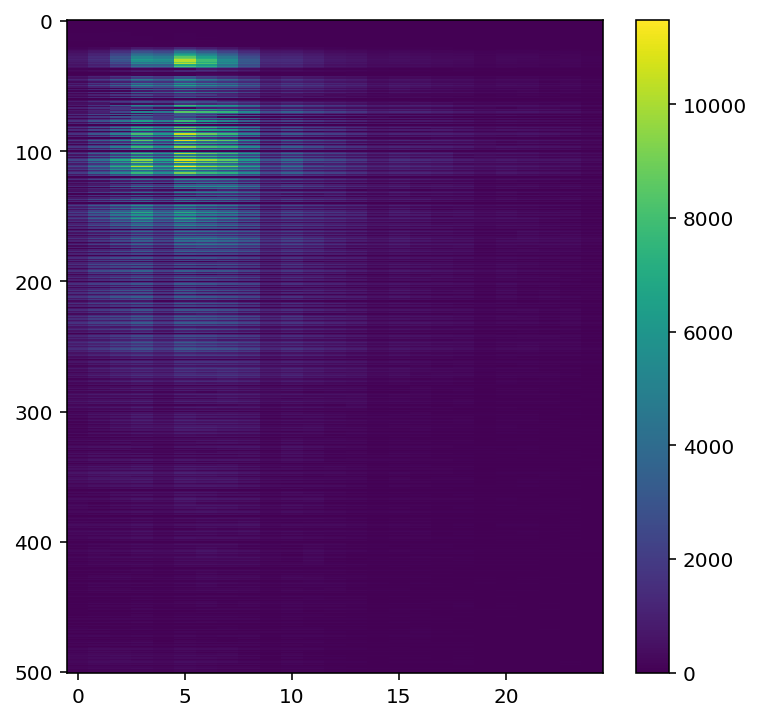

In [87]:
show(np.abs(cdf - interpolated_cdf))

In [88]:
data = []

min_brush = int(pixels / bins)

print("Minimum brush size:", min_brush)

for size in range(min_brush, pixels, 20):
    for start in range(pixels - size):
        end = start + size
        
        hist_a = interpolated_cdf[end] - interpolated_cdf[start]
        hist_b = cdf[end] - cdf[start]
        
        # scaling factor to scale to unfiltered data
        factor = hist_b.max() / unfiltered.max()
#         factor = 1
        
        if sum(hist_a) == 0 and sum(hist_b) == 0:
            w = 0
        if sum(hist_a) == 0 or sum(hist_b) == 0:
            print(f"Skipped comparison because one histogram is zero at {start} with size {size}")
            continue
        else:
            # we are computing the distance over a distribution from 0 to 1
            w = stats.wasserstein_distance(np.arange(bins)/(bins-1), np.arange(bins)/(bins-1), hist_a, hist_b)
            
        w = stats.wasserstein_distance(np.arange(bins)/(bins-1), np.arange(bins)/(bins-1), hist_a, hist_b)
        d = w * factor
        
        sumdiff = hist_a.sum() - hist_b.sum()
        
        data.append([start, size, d, w, hist_a.sum(), hist_b.sum(), sumdiff])
        
distances = pd.DataFrame(data, columns=["start", "size", "distance", "wasserstein", "sum_a", "sum_b", "sumdiff"])

Minimum brush size: 20


In [89]:
print(distances.shape)
distances.head()

(6000, 7)


,start,size,distance,wasserstein,sum_a,sum_b,sumdiff
0,0,20,0.000000,0.000000,1334.0,1334.0,0.0
1,1,20,0.000010,0.033562,8943.4,2642.0,6301.4
2,2,20,0.000019,0.031095,16552.8,5057.0,11495.8
3,3,20,0.000020,0.032454,24162.2,5057.0,19105.2
4,4,20,0.000030,0.029243,31771.6,8122.0,23649.6


Let's get an overview of the distances. We can see that they are all pretty low (great!). 

In [90]:
distances.describe()

,start,size,distance,wasserstein,sum_a,sum_b,sumdiff
count,6000.000000,6000.000000,6000.000000,6000.000000,6.000000e+03,6.000000e+03,6000.000000
mean,162.833333,173.333333,0.000076,0.000438,3.155790e+06,3.152984e+06,2805.246000
std,115.431190,115.287051,0.000088,0.001391,2.597299e+06,2.603944e+06,28731.985459
min,0.000000,20.000000,0.000000,0.000000,1.334000e+03,1.334000e+03,-137460.200000
25%,65.000000,80.000000,0.000016,0.000109,7.986388e+05,7.937170e+05,-2798.100000
50%,143.000000,160.000000,0.000044,0.000229,2.463980e+06,2.453403e+06,3783.175000
75%,244.250000,260.000000,0.000102,0.000418,5.268255e+06,5.264520e+06,17836.287500
max,479.000000,480.000000,0.000731,0.033562,8.362162e+06,8.364801e+06,90785.400000


### Find the item with the worst error

Here we look for the brushes with the highest distance between the interpolated and the true histogram.

In [107]:
worst = distances.loc[distances.wasserstein.idxmax()]
print(worst)

start             1.000000
size             20.000000
distance          0.000010
wasserstein       0.033562
sum_a          8943.400000
sum_b          2642.000000
sumdiff        6301.400000
Name: 1, dtype: float64


In [108]:
# selectivity in %
worst.sumdiff / len(raw) * 100

0.06301400630140062

In [109]:
worst = distances.loc[distances.distance.idxmax()]
print(worst)
print(worst.wasserstein)

start          3.000000e+01
size           4.000000e+01
distance       7.311065e-04
wasserstein    4.680010e-03
sum_a          1.055612e+06
sum_b          1.044072e+06
sumdiff        1.153950e+04
Name: 510, dtype: float64
0.004680009560092084


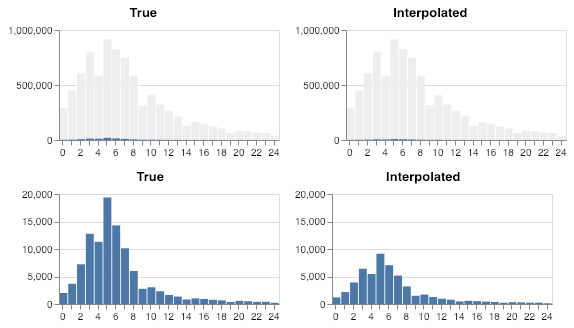

In [97]:
start = int(worst.start)
end = int(worst.start + worst.size)

hists = pd.DataFrame(data={
    'count': cdf[end] - cdf[start],
    'interpolated': interpolated_cdf[end] - interpolated_cdf[start],
    'unfiltered': unfiltered,
    'bins': np.arange(len(unfiltered))
})

base = alt.Chart(hists).mark_bar().encode(
    x=alt.X("bins:O", title=None, axis=alt.Axis(labelAngle=0))
).properties(width=220, height=110)

alt.vconcat(base.properties(title="True").encode(
    y=alt.Y("unfiltered:Q", title=None),
    color=alt.ValueDef("#eee")
) + base.encode(
    y=alt.Y("count:Q", title=None),
) | base.properties(title="Interpolated").encode(
    y=alt.Y("unfiltered:Q", title=None),
    color=alt.ValueDef("#eee")
) + base.encode(
    y=alt.Y("interpolated:Q", title=None),
), base.properties(title="True").encode(
    y=alt.Y("count:Q", title=None, scale=alt.Scale(domain=[0,20000])),
) | base.properties(title="Interpolated").encode(
    y=alt.Y("interpolated:Q", title=None, scale=alt.Scale(domain=[0,20000])),
))

### Error overview

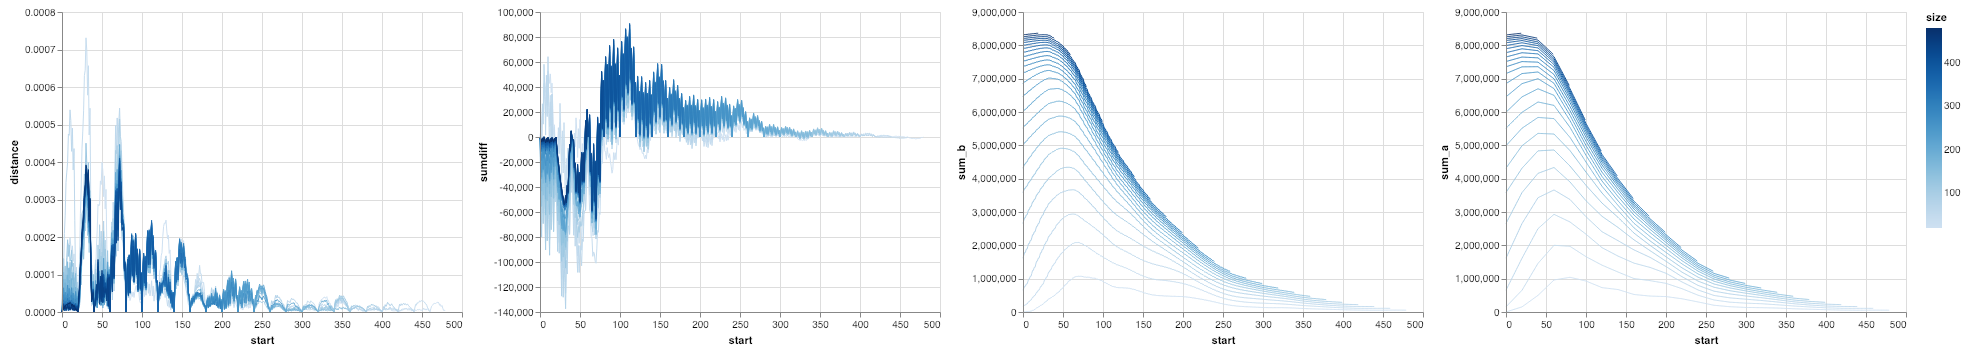

In [93]:
alt.data_transformers.enable('default', max_rows=1000000)

filtered_distances = distances[distances.sum_b > size * 0.05]

alt.Chart(distances).mark_line(strokeWidth=1).encode(
    x="start:Q",
    y="distance:Q",
    color="size:Q"
) | alt.Chart(distances).mark_line(strokeWidth=1).encode(
    x="start:Q",
    y="sumdiff:Q",
    color="size:Q"
) | alt.Chart(distances).mark_line(strokeWidth=1).encode(
    x="start:Q",
    y="sum_b:Q",
    color="size:Q"
) | alt.Chart(distances).mark_line(strokeWidth=1).encode(
    x="start:Q",
    y="sum_a:Q",
    color="size:Q"
)